In [1]:
verbose = False
GPU_SETTING = -1
BASIN = "hopland"  # calpella | warm_springs | hopland | guerneville
MODE = "hourly"     # options are "daily" / "hourly" / "mts"           
RUN_LABEL = "BASELINE"
READ_STAMP = "20250815T000000Z" # Set to the timestamp of the run to read.   

In [2]:
import sys
import os, json
from pathlib import Path
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [3]:
library_path = os.path.join('..', '..', '..', 'UCB-USACE-RR-PROJECT')
sys.path.insert(0, library_path)
current_dir = os.getcwd()
print(current_dir)

/Users/canruso/Desktop/UCB-USACE-RR-PROJECT/notebooks/reload_repredict


In [4]:
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import (data_dir, set_active_context, ensure_shared_tree, repo_root, runs_latest_path, to_path_or_list, ensure_output_tree, prepare_out_path, resolve_run_dirs)

In [5]:
set_active_context(basin=BASIN, resolution=MODE, run_stamp=READ_STAMP, run_tag=RUN_LABEL, append_stamp_to_filenames=False)
SHARED = ensure_shared_tree(BASIN, MODE)

if MODE != "mts":
    ensure_output_tree(BASIN, MODE)

In [6]:
if READ_STAMP:
    RUNS_FILE = (SHARED / "runs" / "archive" /
                 f"{BASIN}_{MODE}_{RUN_LABEL}_stored_runs_{READ_STAMP}.json")
else:
    RUNS_FILE = runs_latest_path(BASIN, MODE, RUN_LABEL)

runs = resolve_run_dirs(RUNS_FILE, basin=BASIN, mode=MODE, label=RUN_LABEL, stamp=READ_STAMP)

In [7]:
SPECIAL_PREFIX = {"warm_springs": "WarmSprings_Inflow"}


BASIN_PREFIX = SPECIAL_PREFIX.get(BASIN.lower(), BASIN.replace("_", " ").title().replace(" ", ""))

d = data_dir()

if MODE == "daily":
    
    candidates = [f"{BASIN_PREFIX}_daily_shift.csv", f"{BASIN_PREFIX}_daily.csv"]
    for fn in candidates:
        p = d / fn
        if p.exists():
            hms_csv = p.resolve()
            break
    else:
        raise FileNotFoundError(f"Daily HMS CSV not found for {BASIN} under {d}")

elif MODE == "hourly":
    p = d / f"{BASIN_PREFIX}_hourly.csv"
    if not p.exists():
        raise FileNotFoundError(f"Hourly HMS CSV not found for {BASIN} under {d}")
    hms_csv = p.resolve()

elif MODE == "mts":
    for fn in [f"{BASIN_PREFIX}_daily_averaged.csv", f"{BASIN_PREFIX}_daily_shift.csv", f"{BASIN_PREFIX}_daily.csv"]:
        p = d / fn
        if p.exists():
            hms_csv_1D = p.resolve()
            break
    else:
        raise FileNotFoundError(f"MTS 1D HMS CSV not found for {BASIN} under {d}")

    p = d / f"{BASIN_PREFIX}_hourly.csv"
    if not p.exists():
        raise FileNotFoundError(f"MTS 1H HMS CSV not found for {BASIN} under {d}")
    hms_csv_1H = p.resolve()

In [8]:
runner_np = UCB_trainer.from_run_dir(runs["no_physics"], gpu=GPU_SETTING, verbose=verbose)
runner_ph = UCB_trainer.from_run_dir(runs["physics"], gpu=GPU_SETTING, verbose=verbose)

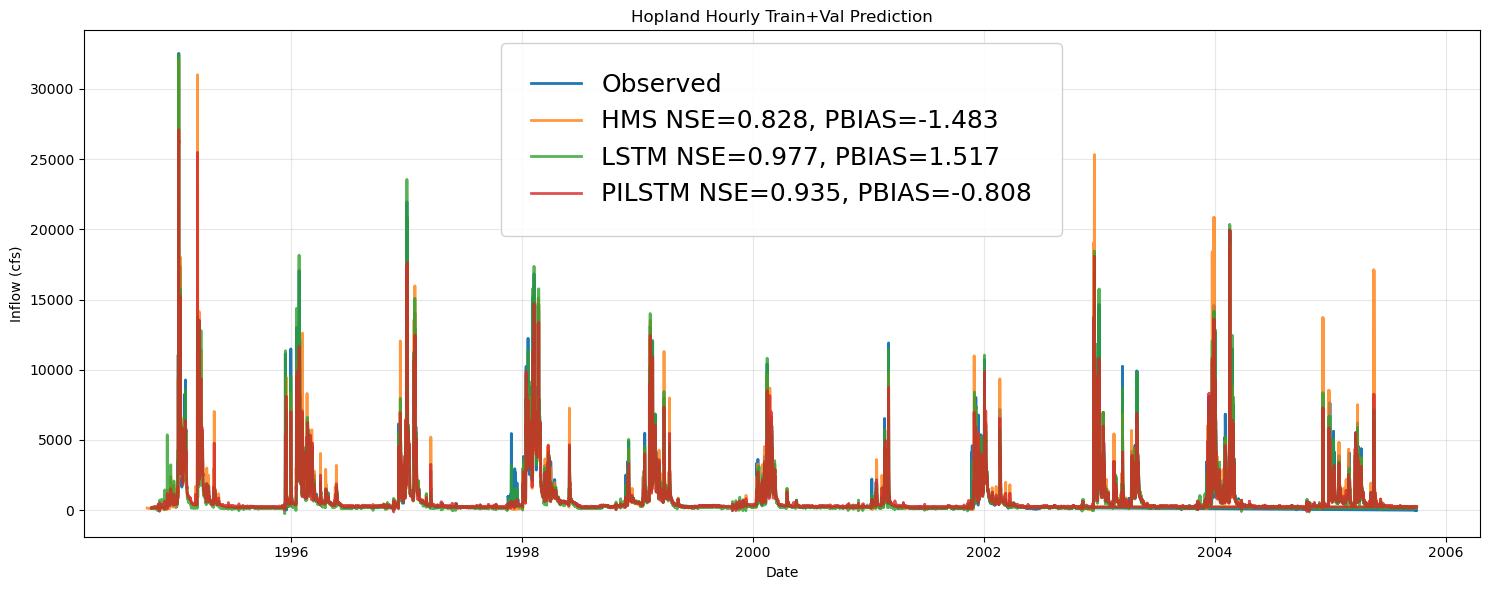

In [9]:
BASIN_TITLE = BASIN.replace("_", " ").title()
basin_file_ctx = (repo_root() / "notebooks/basins" / BASIN.lower()).resolve()
basin_list_name = "warm springs" if BASIN.lower() == "warm_springs" else BASIN.lower()
candidates = [basin_file_ctx / basin_list_name, basin_file_ctx / f"{basin_list_name}.txt"]
basin_list_file = next((p for p in candidates if p.exists()), None)

if basin_file_ctx.exists() and basin_list_file is None:
    existing = ", ".join(sorted(p.name for p in basin_file_ctx.iterdir()))
else:
    existing = "<<folder missing>>"

if basin_list_file is None:
    raise FileNotFoundError("Could not find the basin list file.\n" f"  Basin folder: {basin_file_ctx}\n" f"  Tried: {', '.join(str(p.name) for p in candidates)}\n" f"  In folder: {existing}")

old_cwd = Path.cwd()
try:
    os.chdir(basin_file_ctx)

    if MODE in ("daily", "hourly"):
        plot_tv = prepare_out_path(f"{BASIN}_{MODE}_trainval_ts_predict.png", kind="plot_timeseries", period="train_val")
        ts_tv = prepare_out_path(f"{BASIN}_{MODE}_trainval_ts_predict.csv", kind="timeseries", period="train_val")
        met_tv = prepare_out_path(f"{BASIN}_{MODE}_trainval_metrics_predict.csv", kind="metrics", period="train_val")
        plot_tv.parent.mkdir(parents=True, exist_ok=True); ts_tv.parent.mkdir(parents=True, exist_ok=True); met_tv.parent.mkdir(parents=True, exist_ok=True)

        runner_np.predict(period="train_validation", partner_trainer=runner_ph, hms_csv=hms_csv, metrics=["NSE", "PBIAS"], plot_filename=plot_tv, timeseries_filename=ts_tv, metrics_filename=met_tv, plot_title=f"{BASIN.capitalize()} {MODE.capitalize()} Train+Val Prediction")

    elif MODE == "mts":

        set_active_context(basin=BASIN, resolution="mts_daily", run_stamp=READ_STAMP, run_tag=RUN_LABEL, append_stamp_to_filenames=False)

        plot_tv_1d = prepare_out_path(f"{BASIN}_mts_1D_trainval_ts_predict.png", kind="plot_timeseries", period="train_val")
        ts_tv_1d = prepare_out_path(f"{BASIN}_mts_1D_trainval_ts_predict.csv",  kind="timeseries", period="train_val")
        met_tv_1d = prepare_out_path(f"{BASIN}_mts_1D_trainval_metrics_predict.csv", kind="metrics", period="train_val")
        plot_tv_1d.parent.mkdir(parents=True, exist_ok=True); ts_tv_1d.parent.mkdir(parents=True, exist_ok=True); met_tv_1d.parent.mkdir(parents=True, exist_ok=True)

        runner_np.predict(period="train_validation", partner_trainer=runner_ph, hms_csv=hms_csv_1D, metrics=["NSE", "PBIAS"], plot_filename=plot_tv_1d, timeseries_filename=ts_tv_1d, metrics_filename=met_tv_1d, plot_title=f"{BASIN.capitalize()} MTS 1D Train+Val Prediction", mts_trk="1D")

        set_active_context(basin=BASIN, resolution="mts_hourly", run_stamp=READ_STAMP, run_tag=RUN_LABEL, append_stamp_to_filenames=False)

        plot_tv_1h = prepare_out_path(f"{BASIN}_mts_1H_trainval_ts_predict.png", kind="plot_timeseries", period="train_val")
        ts_tv_1h = prepare_out_path(f"{BASIN}_mts_1H_trainval_ts_predict.csv", kind="timeseries", period="train_val")
        met_tv_1h = prepare_out_path(f"{BASIN}_mts_1H_trainval_metrics_predict.csv", kind="metrics", period="train_val")
        plot_tv_1h.parent.mkdir(parents=True, exist_ok=True); ts_tv_1h.parent.mkdir(parents=True, exist_ok=True); met_tv_1h.parent.mkdir(parents=True, exist_ok=True)

        runner_np.predict(period="train_validation", partner_trainer=runner_ph, hms_csv=hms_csv_1H, metrics=["NSE", "PBIAS"], plot_filename=plot_tv_1h, timeseries_filename=ts_tv_1h, metrics_filename=met_tv_1h, plot_title=f"{BASIN.capitalize()} MTS 1H Train+Val Prediction", mts_trk="1H")


finally:
    os.chdir(old_cwd)